In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2

In [2]:
train_path = "./04_multimodal_training/"
filenames = os.listdir(train_path)

labels = []
kinds = []

for i in range(0, len(filenames)):
    label = filenames[i][:3]
    kind = filenames[i][4]
    labels.append(label)
    kinds.append(kind)

df = pd.DataFrame({'filename':filenames, 'label':labels, 'kind':kinds})
df

,filename,label,kind
0,000_face_0001.BMP,000,f
1,000_face_0002.BMP,000,f
2,000_face_0003.BMP,000,f
3,000_face_0004.BMP,000,f
4,000_iris_0.png,000,i
...,...,...,...
507,063_face_0004.BMP,063,f
508,063_iris_0.png,063,i
509,063_iris_1.png,063,i
510,063_iris_2.png,063,i


(56, 46, 3)


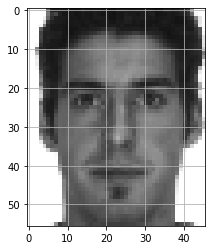

(51, 42, 3)


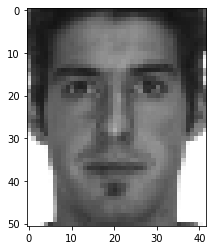

(288, 320, 3)


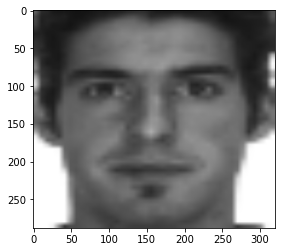

In [35]:
img = cv2.imread(train_path + df.iloc[0,0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)
plt.grid(True)
plt.imshow(img)
plt.show()

crop_img=img[5:60,3:45]
print(crop_img.shape)
plt.grid(False)
plt.imshow(crop_img)
plt.show()

resize_img = cv2.resize(crop_img, (320, 288))
print(resize_img.shape)
plt.grid(False)
plt.imshow(resize_img)
plt.show()

In [36]:
def load_img(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[5:60,3:45]
    img = cv2.resize(img, (320, 288))
    return img

In [37]:
aug_path = "./04_multimodal_aug/"

In [39]:
aug_datagen = ImageDataGenerator(
    zoom_range=0.075,
    width_shift_range=0.075,
    height_shift_range=0.075,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
)

for i in range(df.shape[0]):
    img = load_img(train_path + df['filename'][i])
    cv2.imwrite(aug_path + df['filename'][i], cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[-1])
    j = 1
    for batch in aug_datagen.flow(x=img, save_to_dir=aug_path, save_format="png",
                                  save_prefix=df['label'][i]+df['kind'][i],
                                  batch_size=1):
        j = j+1
        if j>5:
            break

In [ ]:
filenames = os.listdir(aug_path)

labels = []
kinds = []

for i in range(0, len(filenames)):
    label = filenames[i][:3]
    kind = filenames[i][3]
    labels.append(label)
    kinds.append(kind)

df = pd.DataFrame({'filename':filenames, 'label':labels, 'kind':kinds})
df

In [ ]:
def load_scale_reshape(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[-1])
    return img

In [ ]:
X = load_scale_reshape(aug_path + df['filename'][0])

for i in range(1, df.shape[0]):
    img = load_scale_reshape(aug_path + df['filename'][i])
    X = np.concatenate((X, img), axis=0)

print(X.shape)

Y = df['label']
Y = pd.get_dummies(Y)
print(Y.shape)

In [ ]:
IMAGE_WIDTH = X.shape[1]
IMAGE_HEIGHT = X.shape[2]
IMAGE_CHANNELS = X.shape[-1]
OUTPUT_SIZE = len(df['label'].unique())

In [ ]:
def create_model():
    input = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_tensor=input)
    
    for layer in base_model.layers[:44]:
        layer.trainable = False
    
    X = base_model.output
    X = BatchNormalization()(X)
    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.3)(X)
    
    X = Dense(512, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)
    
    Y = Dense(OUTPUT_SIZE, activation='softmax')(X)
    
    model = tf.keras.Model(inputs = input, outputs = Y)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000075),
                 metrics=['accuracy', Precision(), Recall()])
    model.summary()
    
    return model

In [ ]:
def acc_graph(history):
    from pylab import rcParams
    from matplotlib import pyplot as plt
    rcParams['figure.figsize'] = 10, 4
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
batch_size = 32
epoch = 20
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
scores =[]

skf = StratifiedKFold(n_splits=3, shuffle=True)

for train_index, val_index in skf.split(X, df['label']):
    train_X, val_X = X[train_index], X[val_index]
    train_Y, val_Y = Y.iloc[train_index], Y.iloc[val_index]
    
    model = create_model()
    
    history = model.fit(train_X, train_Y, batch_size=batch_size, epochs=epoch,
                   validation_data = (val_X, val_Y), callbacks=[es])

    acc_graph(history)

    evaluation = model.evaluate(val_X, val_Y, batch_size = batch_size)
    scores.append(evaluation)

In [ ]:
scores_df = pd.DataFrame(scores, columns=['loss','accuracy','precision', 'recall'])

In [ ]:
scores_df['f1-score'] = (2*scores_df['precision']*scores_df['recall'])/(scores_df['precision']+scores_df['recall'])

In [ ]:
scores_df

In [ ]:
scores_df.mean()

In [ ]:
def test_load(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[:, 60:700]
    img = cv2.resize(img, (320, 288))
    img = img/255.
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[-1])
    return img

In [ ]:
test_path = "./03_iris_test/"
filenames = os.listdir(test_path)

nums = []
for i in range(0, len(filenames)):
    num = filenames[i].split('.')[0]
    nums.append(num)

test_df = pd.DataFrame({'num':nums, 'filename':filenames}) 
test_df = test_df.astype({'num':'uint16'})

test_X = test_load(test_path+test_df['filename'][0])

for i in range(1,test_df.shape[0]):
    img = test_load(test_path+test_df['filename'][i])
    test_X = np.concatenate((test_X, img), axis=0)

print(test_X.shape)

In [ ]:
pred = pd.DataFrame(model.predict(test_X))
pred = pred.round(decimals=2)
pred

In [ ]:
answer = pred.idxmax(axis=1)+1

In [ ]:
test_df = pd.concat([test_df, answer, pred], axis=1)
test_df = test_df.sort_values(by=['num'])

In [ ]:
col = ['Image', 'Filename', 'Answer']
for i in range(OUTPUT_SIZE):
    col.append('pred_'+str(i+1))
test_df.columns = col

In [ ]:
test_df

In [ ]:
ans_df = test_df[['Image', 'Answer']]
ans_df

In [ ]:
ans_df.to_csv('./answer.csv', header=True, index=False)